# 1. Importing libraries and loading data

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import sweetviz as sv
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.pipeline import Pipeline
import pickle
%matplotlib inline
from functools import partial
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from matplotlib.pyplot import ticklabel_format
#pip install xlrd
#pip install pickle-mixin
#pip install geopy

In [2]:
df = pd.read_excel("../data/raw/Seattle-housing-regression_data.xls")

In [3]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


# 2. EDA and Data Cleaning

In [4]:
df['waterfront'].value_counts()

0    21434
1      163
Name: waterfront, dtype: int64

In [5]:
df['view'].value_counts()

0    19475
2      961
3      510
1      332
4      319
Name: view, dtype: int64

In [6]:
df.shape

(21597, 21)

In [7]:
nulls_percent_df = pd.DataFrame(df.isna().sum()/len(df)).reset_index()
nulls_percent_df.columns = ['column_name', 'nulls_percentage']
nulls_percent_df

,column_name,nulls_percentage
0,id,0.0
1,date,0.0
2,bedrooms,0.0
3,bathrooms,0.0
4,sqft_living,0.0
5,sqft_lot,0.0
6,floors,0.0
7,waterfront,0.0
8,view,0.0
9,condition,0.0


From the date sold and date built, the age of the house can be calculated.

In [8]:
age = [df['date'][index].year - df['yr_built'][index] for index in range(df.shape[0])]

df["house_age"] = age

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [10]:
df.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,house_age
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000
mean,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,...,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05,43.323286
std,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,...,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05,29.377285
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,...,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04,-1.000000
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05,18.000000
50%,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05,40.000000
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05,63.000000
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06,115.000000


In [11]:
df['id'].duplicated().sum() # Perhaps 177 houses were sold several times.

177

## Cleaning the duplicated houses keeping the latest one

In [12]:
indexes_of_duplicated_houses = list(df[df['id'].duplicated()].index)

In [13]:
df.iloc[indexes_of_duplicated_houses,:]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,house_age
94,6021501535,2014-12-23,3,1.50,1580,5000,1.0,0,0,3,...,290,1939,0,98117,47.6870,-122.386,1570,4500,700000,75
314,4139480200,2014-12-09,4,3.25,4290,12103,1.0,0,3,3,...,1600,1997,0,98006,47.5503,-122.102,3860,11244,1400000,17
325,7520000520,2015-03-11,2,1.00,1240,12092,1.0,0,0,3,...,280,1922,1984,98146,47.4957,-122.352,1820,7460,240500,93
346,3969300030,2014-12-29,4,1.00,1000,7134,1.0,0,0,3,...,0,1943,0,98178,47.4897,-122.240,1020,7138,239900,71
372,2231500030,2015-03-24,4,2.25,2180,10754,1.0,0,0,5,...,1080,1954,0,98133,47.7711,-122.341,1810,6929,530000,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20165,7853400250,2015-02-19,4,3.50,2910,5260,2.0,0,0,3,...,0,2012,0,98065,47.5168,-121.883,2910,5260,645000,3
20597,2724049222,2014-12-01,2,2.50,1000,1092,2.0,0,0,3,...,10,2004,0,98118,47.5419,-122.271,1330,1466,220000,10
20654,8564860270,2015-03-30,4,2.50,2680,5539,2.0,0,0,3,...,0,2013,0,98045,47.4759,-121.734,2680,5992,502000,2
20764,6300000226,2015-05-04,4,1.00,1200,2171,1.5,0,0,3,...,0,1933,0,98133,47.7076,-122.342,1130,1598,380000,82


In [14]:
df[df['id']==6021501535] # As example

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,house_age
93,6021501535,2014-07-25,3,1.5,1580,5000,1.0,0,0,3,...,290,1939,0,98117,47.687,-122.386,1570,4500,430000,75
94,6021501535,2014-12-23,3,1.5,1580,5000,1.0,0,0,3,...,290,1939,0,98117,47.687,-122.386,1570,4500,700000,75


In [15]:
duplicated_ids = df[df['id'].duplicated()==True]["id"].values.tolist()

In [16]:
duplicated_ids[:2]

[6021501535, 4139480200]

In [17]:
indexes_to_drop = []

for duplicated_id in duplicated_ids:
    indexes_to_drop.extend(list(df[df["id"]==duplicated_id].sort_values(by="date").index[:-1])) # ASCENDING BY default

indexes_to_drop

[93,
 313,
 324,
 345,
 371,
 717,
 823,
 836,
 1084,
 1127,
 1200,
 1232,
 1448,
 1462,
 1574,
 1862,
 2036,
 2124,
 2491,
 2494,
 2500,
 2529,
 2562,
 2629,
 2974,
 3031,
 3295,
 3536,
 3619,
 3752,
 3781,
 3789,
 3874,
 3946,
 4073,
 4338,
 4867,
 4917,
 5239,
 5246,
 5267,
 5335,
 5587,
 5689,
 5718,
 5751,
 5753,
 5966,
 6339,
 6365,
 6428,
 6527,
 6624,
 6713,
 6783,
 6896,
 7171,
 7238,
 7785,
 7838,
 7840,
 8004,
 8118,
 8267,
 8333,
 8426,
 8496,
 8523,
 8621,
 8895,
 8906,
 9007,
 9105,
 9111,
 9225,
 9266,
 9268,
 9270,
 9383,
 9430,
 9480,
 9497,
 9711,
 9810,
 9865,
 10210,
 10215,
 10242,
 10246,
 10261,
 10308,
 10598,
 10904,
 10957,
 11049,
 11182,
 11190,
 11275,
 11350,
 11421,
 11446,
 11574,
 11763,
 12018,
 12053,
 12109,
 12196,
 12320,
 12326,
 12365,
 12376,
 12405,
 12422,
 12819,
 12907,
 12942,
 13010,
 13170,
 13285,
 13604,
 13615,
 13646,
 13679,
 13721,
 13743,
 14207,
 14294,
 14353,
 14470,
 14560,
 14841,
 14968,
 14979,
 14987,
 15132,
 15142,
 15185

In [18]:
len(indexes_to_drop)

179

In [19]:
df.drop(indexes_to_drop,axis=0, inplace=True)

In [20]:
df.shape

(21420, 22)

In [21]:
df[df["bedrooms"]>9] # to check if high bedroom numbers look feasible

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,house_age
8748,1773100755,2014-08-21,11,3.00,3000,4960,2.0,0,0,3,...,600,1918,1999,98106,47.5560,-122.363,1420,4960,520000,96
13301,627300145,2014-08-14,10,5.25,4590,10920,1.0,0,2,3,...,2090,2008,0,98004,47.5861,-122.113,2730,10400,1150000,6
15147,5566100170,2014-10-29,10,2.00,3610,11914,2.0,0,0,4,...,600,1958,0,98006,47.5705,-122.175,2040,11914,650000,56
15856,2402100895,2014-06-25,33,1.75,1620,6000,1.0,0,0,5,...,580,1947,0,98103,47.6878,-122.331,1330,4700,640000,67
19239,8812401450,2014-12-29,10,3.00,2920,3745,2.0,0,0,4,...,1060,1913,0,98105,47.6635,-122.320,1810,3745,660000,101


Comparing different features here and in MySQL the row with number of bedrooms= 33, seems outrageous. Dropping it:

In [22]:
df = df[df['bedrooms']!=33]
df.reset_index(drop=True, inplace=True)

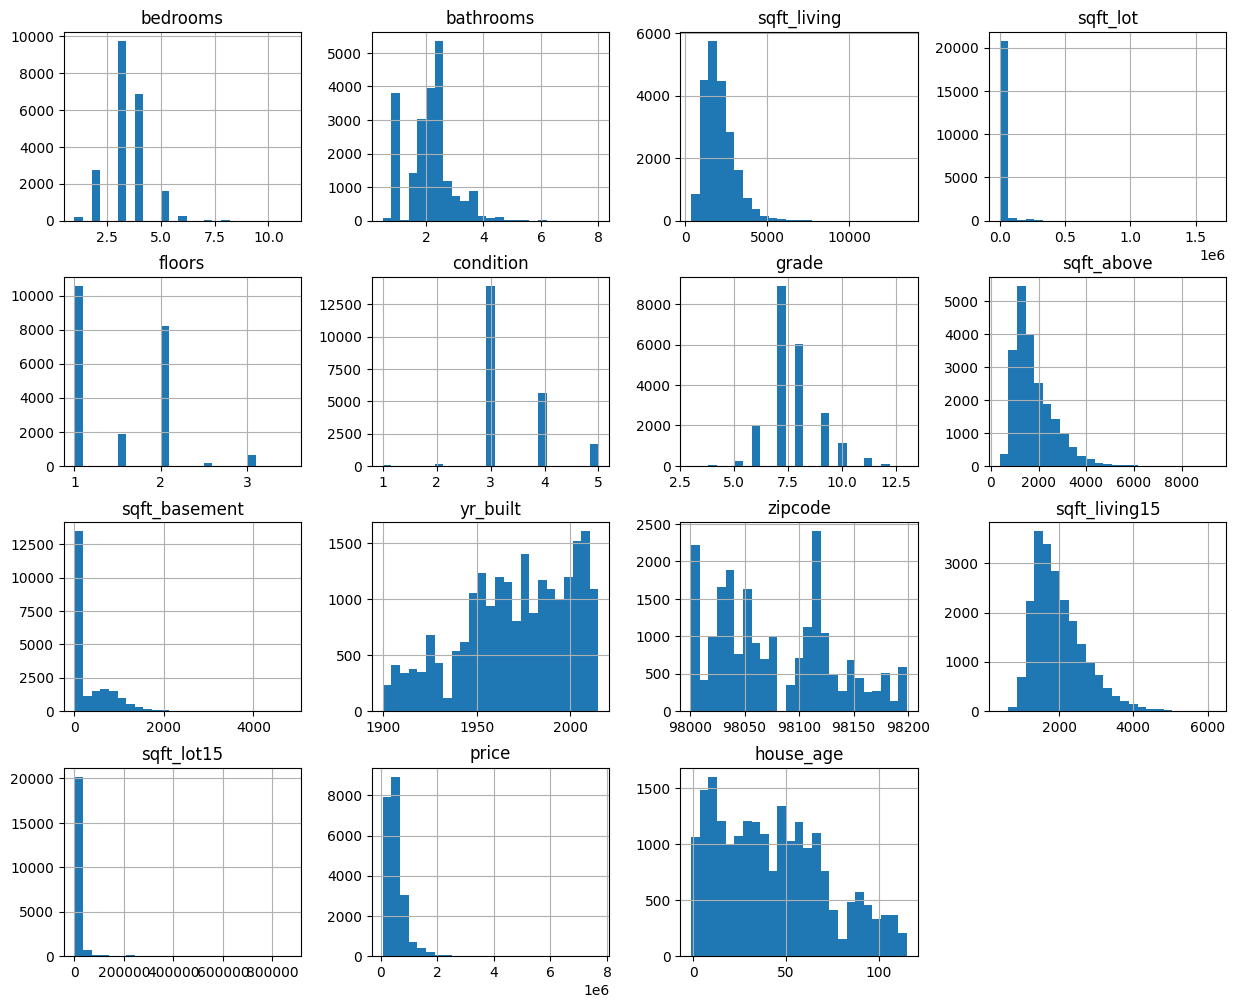

In [23]:
# showing some features on a histogram
df_h=df.loc[:, df.columns.drop(['id', 'waterfront', 'view', 'yr_renovated', 'date', 'lat', 'long'])]
df_h = df_h[df_h['bedrooms']!=33]
df_h.reset_index(drop=True, inplace=True)

df_h_list =df_h.hist(bins=25, layout=(4,4), figsize=(15,12))
plt.savefig("../visualization/histogram", transparent=True)

In [24]:
df['yr_renovated'].unique() # to check if it is important for the model #it may be important

array([   0, 1991, 2002, 2010, 1999, 1992, 2013, 1994, 1978, 2005, 2008,
       2003, 1984, 1954, 2014, 2011, 1974, 1983, 1945, 1990, 1988, 1957,
       1977, 1981, 1995, 2000, 1998, 1970, 1989, 2004, 1986, 2009, 2007,
       1987, 1973, 2006, 1985, 2001, 1980, 1971, 1979, 1997, 1950, 1969,
       1948, 2015, 1968, 2012, 1963, 1951, 1993, 1962, 1996, 1972, 1953,
       1955, 1982, 1956, 1940, 1976, 1946, 1975, 1958, 1964, 1959, 1960,
       1967, 1965, 1934, 1944], dtype=int64)

In [25]:
yr_after_renovation = [df['date'][index].year - df['yr_renovated'][index] for index in range(df.shape[0])]

df["yr_after_renovation"] = yr_after_renovation

In [26]:
# Using 0 for those which are not renovated.
def no_renovation(x):
    if x > 300: # To ensure all the houses are counted. The oldest is 80 in this dataset.
        return 0
    else:
        return x

In [27]:
#For the first model it is decided to take into account only how many years have passed after the renovation.
df['yr_after_renovation']=list(map(no_renovation,df['yr_after_renovation']))

In [28]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,house_age,yr_after_renovation
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1955,0,98178,47.5112,-122.257,1340,5650,221900,59,0
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,1951,1991,98125,47.7210,-122.319,1690,7639,538000,63,23
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,1933,0,98028,47.7379,-122.233,2720,8062,180000,82,0
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1965,0,98136,47.5208,-122.393,1360,5000,604000,49,0
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1987,0,98074,47.6168,-122.045,1800,7503,510000,28,0


In [29]:
df2 = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'house_age', 'yr_after_renovation', 'price']]

In [30]:
df2

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,house_age,yr_after_renovation,price
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,98178,47.5112,-122.257,1340,5650,59,0,221900
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,98125,47.7210,-122.319,1690,7639,63,23,538000
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,98028,47.7379,-122.233,2720,8062,82,0,180000
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,98136,47.5208,-122.393,1360,5000,49,0,604000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,98074,47.6168,-122.045,1800,7503,28,0,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21414,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,98103,47.6993,-122.346,1530,1509,5,0,360000
21415,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,98146,47.5107,-122.362,1830,7200,1,0,400000
21416,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,98144,47.5944,-122.299,1020,2007,5,0,402101
21417,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,98027,47.5345,-122.069,1410,1287,11,0,400000


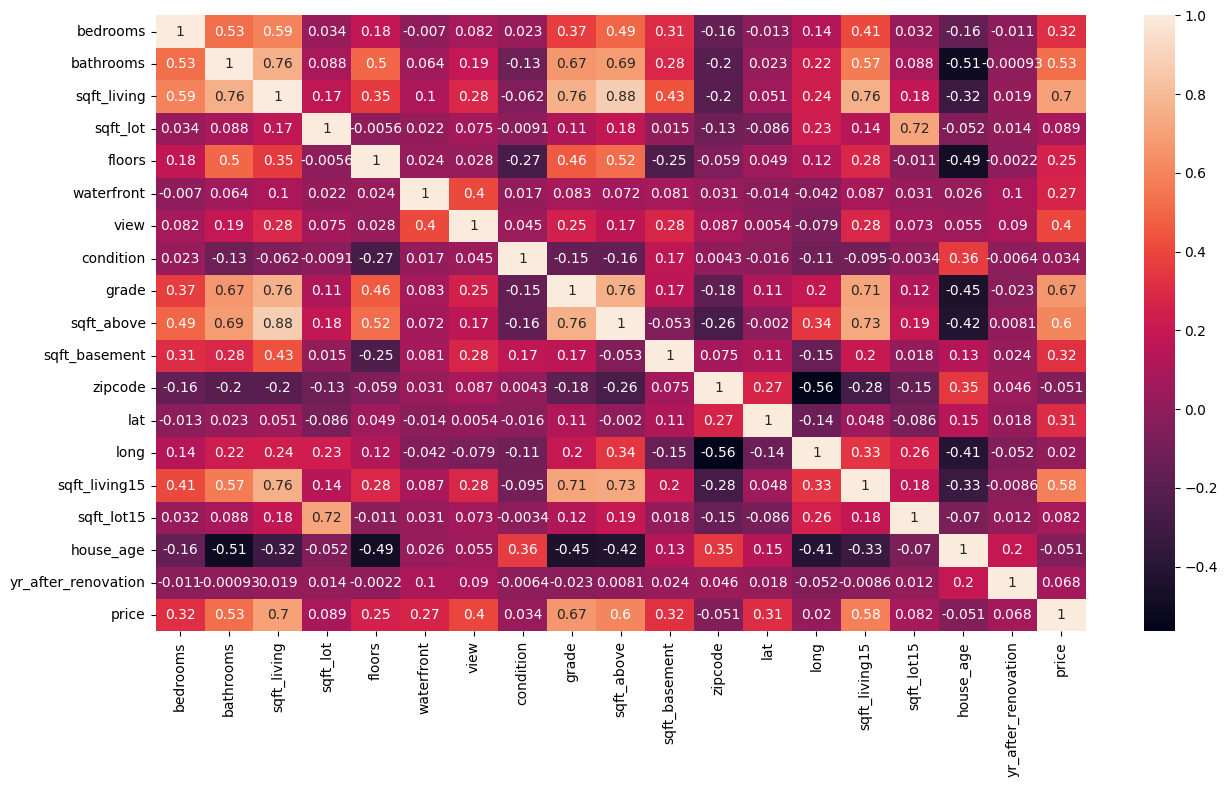

In [31]:
# Correlation Matrix for price:
plt.figure(figsize = (15,8))
sns.heatmap(df2.corr(), annot=True)
plt.savefig(f"../visualization/ price_vs_features", transparent=True)

This correlation matrix shows linear relationship with the price. Here, we see sqft_living, grade and sqft_above have some linear relationship and others does not- which does not make any sense. Therefore, from this matrix, linear regression model can be discarded already. 

In [32]:
report = sv.analyze(df2)
report.show_html("../visualization/report_1.html")

                                             |                                             | [  0%]   00:00 ->…

Report ../visualization/report_1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [33]:
df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price', 'house_age',
       'yr_after_renovation'],
      dtype='object')

In [34]:
df = df[['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'house_age',
       'yr_after_renovation', 'price']]

In [35]:
clean_housing = df.to_csv("../data/clean/clean_housing.csv", index=False)

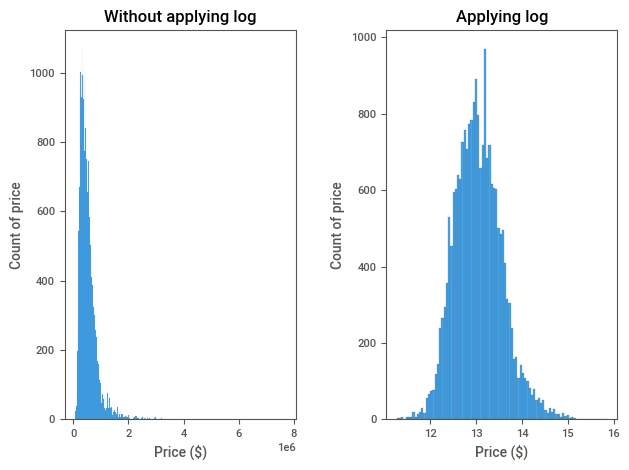

In [36]:
# the real price data is highly skewed, therefore it is better to use log to predict the price
fig, ax = plt.subplots(1,2)

sns.histplot(df['price'],ax=ax[0]);
ax[0].set_xlabel("Price ($)")
ax[0].set_ylabel("Count of price")
ax[0].set_title("Without applying log")
#ax[0].set_xscale("log")
#ax[0].set_yscale("log")
sns.histplot(np.log(df['price']),ax=ax[1]);
ax[1].set_xlabel("Price ($)")
ax[1].set_ylabel("Count of price")
ax[1].set_title("Applying log")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")
plt.tight_layout()
ax[0].ticklabel_format(axis="x",style="sci",scilimits=(0,0))
#ax[0].ticklabel_format(axis="y",style="sci",scilimits=(0,0))
#ax[1].ticklabel_format(axis="x",style="sci",scilimits=(0,0))
#ax[1].ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.show()
fig.savefig('../visualization/hist_withlog_Vs_without.png', transparent=True)

# 3. Model Comparison

In [37]:
y = df['price'] #set y
X = df.drop(['price', 'date', 'id', 'yr_built', 'yr_renovated'], axis = 1) #set X - drop yr_built since it has been considered in house_age, drop yr_renovated since a dummy variable has been created, and drop date since it cannot be converted in a float
X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,house_age,yr_after_renovation
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,98178,47.5112,-122.257,1340,5650,59,0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,98125,47.7210,-122.319,1690,7639,63,23
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,98028,47.7379,-122.233,2720,8062,82,0
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,98136,47.5208,-122.393,1360,5000,49,0
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,98074,47.6168,-122.045,1800,7503,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21414,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,98103,47.6993,-122.346,1530,1509,5,0
21415,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,98146,47.5107,-122.362,1830,7200,1,0
21416,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,98144,47.5944,-122.299,1020,2007,5,0
21417,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,98027,47.5345,-122.069,1410,1287,11,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=5)

## Base Model : Linear Regression

In [39]:
lr=LinearRegression() # model defined

LinReg = lr.fit(X_train, y_train) #training the model

with open("../models/LinReg.pkl", "wb") as file:
    pickle.dump(LinReg, file)

# predicting y with X_test
y_pred=LinReg.predict(X_test) 

r2 = r2(y_test, y_pred) # calculating r2 
mean_sq_err = mse(y_test, y_pred) # calculating mean squared error
mean_abs_err = mae(y_test, y_pred) # calculating absolute error

print("The metrics of the basic model are the following:")
print('r2: ', round(r2,2))
print('MAE: ', round(mean_abs_err,2))
print('MSE: ', round(mean_sq_err,2))
print('RMSE: ', round(np.sqrt(mean_sq_err),2))

The metrics of the basic model are the following:
r2:  0.72
MAE:  125740.22
MSE:  42417250180.96
RMSE:  205954.49


## Model Automation

### Standardize

In [40]:
# Standardize--fit--save--transform
std_scaler = StandardScaler()
std_scaler.fit(X_train)

with open("../scalers/standard_scaler.pkl", "wb") as file:
    pickle.dump(std_scaler, file)
    
X_train_scaled_np = std_scaler.transform(X_train) # np because numpy array
X_test_scaled_np = std_scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)
X_train_scaled_df

X_test_scaled_df = pd.DataFrame(X_test_scaled_np, columns=X_test.columns)
X_test_scaled_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,house_age,yr_after_renovation
0,1.818468,1.160418,0.473044,-0.275445,0.009125,-0.08398,3.625187,2.460122,0.294914,-0.239366,1.429739,1.232429,0.263523,-0.539791,0.298078,-0.273498,1.550249,-0.161411
1,-0.409913,-0.478425,-0.041749,0.193149,-0.916082,-0.08398,-0.305642,0.916973,0.294914,0.305204,-0.659191,-0.671510,-1.504411,0.529947,-0.053495,-0.241057,-0.317296,-0.161411
2,-0.409913,-0.150657,-0.096515,4.765223,-0.916082,-0.08398,-0.305642,-0.626175,-0.562603,0.244696,-0.659191,-1.044832,-2.234974,1.250237,1.133066,7.692010,0.735320,-0.161411
3,-0.409913,0.177112,0.275889,-0.091243,0.934332,-0.08398,-0.305642,0.916973,0.294914,0.656149,-0.659191,-0.484849,0.565277,0.743895,0.092994,-0.047230,-0.419162,-0.161411
4,-0.409913,-1.461731,-1.158960,1.027549,-0.916082,-0.08398,-0.305642,-0.626175,-0.562603,-0.929154,-0.659191,-0.671510,-1.275569,0.943579,-0.727345,0.001414,0.361811,-0.161411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4279,0.704277,0.504880,-0.162233,-0.222372,0.934332,-0.08398,-0.305642,-0.626175,0.294914,0.172087,-0.659191,-0.895503,-1.466150,0.166236,-0.082793,-0.245257,-0.962448,-0.161411
4280,-1.524103,-0.478425,-0.600355,-0.291142,-0.916082,-0.08398,1.004634,0.916973,-0.562603,-1.159084,0.930212,0.765777,0.552283,-1.117450,-1.034972,-0.419168,1.855847,-0.161411
4281,-0.409913,-0.150657,-0.041749,-0.258410,-0.916082,-0.08398,-0.305642,0.916973,-0.562603,-0.929154,1.656797,0.896440,-0.030291,-1.160239,-0.507612,-0.296564,1.550249,-0.161411
4282,-0.409913,-0.478425,0.023969,-0.251899,-0.916082,-0.08398,2.314911,-0.626175,-0.562603,-0.541905,1.066447,0.896440,0.101095,-1.167371,-0.507612,-0.289063,1.040918,-0.161411


### KNN best parameters

In [41]:
# Determine the best parameters for KNN
knn_models = []
scores = []
for k in range(2,35):
    model = KNeighborsRegressor(n_neighbors=k)
    print("Training the k-NN model with {} neihgbours...".format(k))
    model.fit(X_train_scaled_df, np.log(y_train))
    knn_models.append(model)
    y_train_pred = np.exp(model.predict(X_train_scaled_df))
    y_test_pred  = np.exp(model.predict(X_test_scaled_df))
    scores.append(r2_score(y_test,y_test_pred))
    #scores.append(model.score(X_test_scaled_df,np.log(y_test)))
    print()

Training the k-NN model with 2 neihgbours...

Training the k-NN model with 3 neihgbours...

Training the k-NN model with 4 neihgbours...

Training the k-NN model with 5 neihgbours...

Training the k-NN model with 6 neihgbours...

Training the k-NN model with 7 neihgbours...

Training the k-NN model with 8 neihgbours...

Training the k-NN model with 9 neihgbours...

Training the k-NN model with 10 neihgbours...

Training the k-NN model with 11 neihgbours...

Training the k-NN model with 12 neihgbours...

Training the k-NN model with 13 neihgbours...

Training the k-NN model with 14 neihgbours...

Training the k-NN model with 15 neihgbours...

Training the k-NN model with 16 neihgbours...

Training the k-NN model with 17 neihgbours...

Training the k-NN model with 18 neihgbours...

Training the k-NN model with 19 neihgbours...

Training the k-NN model with 20 neihgbours...

Training the k-NN model with 21 neihgbours...

Training the k-NN model with 22 neihgbours...

Training the k-NN mod

In [49]:
for index,score in enumerate(scores):
    print("The R2 of the k-nn model with {} neighbours on the TEST set was: {:.3f}".format(index+2,score))

The R2 of the k-nn model with 2 neighbours on the TEST set was: 0.793
The R2 of the k-nn model with 3 neighbours on the TEST set was: 0.810
The R2 of the k-nn model with 4 neighbours on the TEST set was: 0.808
The R2 of the k-nn model with 5 neighbours on the TEST set was: 0.811
The R2 of the k-nn model with 6 neighbours on the TEST set was: 0.809
The R2 of the k-nn model with 7 neighbours on the TEST set was: 0.806
The R2 of the k-nn model with 8 neighbours on the TEST set was: 0.802
The R2 of the k-nn model with 9 neighbours on the TEST set was: 0.799
The R2 of the k-nn model with 10 neighbours on the TEST set was: 0.802
The R2 of the k-nn model with 11 neighbours on the TEST set was: 0.799
The R2 of the k-nn model with 12 neighbours on the TEST set was: 0.797
The R2 of the k-nn model with 13 neighbours on the TEST set was: 0.795
The R2 of the k-nn model with 14 neighbours on the TEST set was: 0.794
The R2 of the k-nn model with 15 neighbours on the TEST set was: 0.790
The R2 of the 

In [50]:
knn_models_weighted = []
scores_weighted = []
for k in range(2,35):
    model = KNeighborsRegressor(n_neighbors=k, weights="distance")
    print("Training the k-NN model with {} neihgbours...".format(k))
    model.fit(X_train_scaled_df, np.log(y_train))
    knn_models_weighted.append(model)
    y_train_pred = np.exp(model.predict(X_train_scaled_df))
    y_test_pred  = np.exp(model.predict(X_test_scaled_df))
    scores_weighted.append(r2_score(y_test,y_test_pred))
    
    print()

Training the k-NN model with 2 neihgbours...

Training the k-NN model with 3 neihgbours...

Training the k-NN model with 4 neihgbours...

Training the k-NN model with 5 neihgbours...

Training the k-NN model with 6 neihgbours...

Training the k-NN model with 7 neihgbours...

Training the k-NN model with 8 neihgbours...

Training the k-NN model with 9 neihgbours...

Training the k-NN model with 10 neihgbours...

Training the k-NN model with 11 neihgbours...

Training the k-NN model with 12 neihgbours...

Training the k-NN model with 13 neihgbours...

Training the k-NN model with 14 neihgbours...

Training the k-NN model with 15 neihgbours...

Training the k-NN model with 16 neihgbours...

Training the k-NN model with 17 neihgbours...

Training the k-NN model with 18 neihgbours...

Training the k-NN model with 19 neihgbours...

Training the k-NN model with 20 neihgbours...

Training the k-NN model with 21 neihgbours...

Training the k-NN model with 22 neihgbours...

Training the k-NN mod

In [51]:
for index,score in enumerate(scores_weighted):
    print("The R2 of the k-nn model with {} neighbours on the TEST set was: {:.3f}".format(index+2,score))

The R2 of the k-nn model with 2 neighbours on the TEST set was: 0.793
The R2 of the k-nn model with 3 neighbours on the TEST set was: 0.812
The R2 of the k-nn model with 4 neighbours on the TEST set was: 0.811
The R2 of the k-nn model with 5 neighbours on the TEST set was: 0.816
The R2 of the k-nn model with 6 neighbours on the TEST set was: 0.814
The R2 of the k-nn model with 7 neighbours on the TEST set was: 0.812
The R2 of the k-nn model with 8 neighbours on the TEST set was: 0.809
The R2 of the k-nn model with 9 neighbours on the TEST set was: 0.806
The R2 of the k-nn model with 10 neighbours on the TEST set was: 0.809
The R2 of the k-nn model with 11 neighbours on the TEST set was: 0.805
The R2 of the k-nn model with 12 neighbours on the TEST set was: 0.804
The R2 of the k-nn model with 13 neighbours on the TEST set was: 0.802
The R2 of the k-nn model with 14 neighbours on the TEST set was: 0.801
The R2 of the k-nn model with 15 neighbours on the TEST set was: 0.797
The R2 of the 

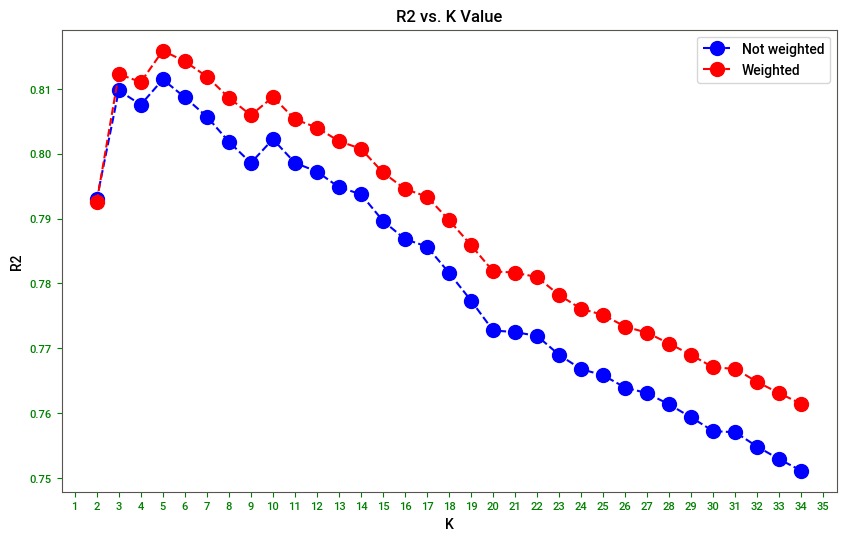

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(2,35),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='blue', markersize=10, label = "Not weighted")
ax.plot(range(2,35),scores_weighted,color = 'red', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10, label = "Weighted")
plt.title('R2 vs. K Value')
plt.xticks(range(1,36))
#plt.gca().invert_yaxis()
plt.xlabel('K')
plt.ylabel('R2')
plt.legend()
ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue

ax.tick_params(axis='x', colors='green')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='green')  #setting up Y-axis tick color to black
fig.savefig('../visualization/R2_Vs_K.png', transparent=True)

Both graphs show similar best values for K: 5 or 10. I am saving weighted model because it provides better R2.

In [53]:
with open("../models/knn_10_distance.pkl", "wb") as file:
    pickle.dump(knn_models_weighted[8], file)

In [54]:
with open("../models/knn_5_distance.pkl", "wb") as file:
    pickle.dump(knn_models_weighted[3], file)

### SGD best parameters

In [67]:
loss= ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
penalty = ['l2', 'l1']
max_iter=[10000,20000]
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

In [68]:
grid = {'loss': loss,
        'penalty': penalty,
       'max_iter':max_iter}

In [69]:
gs_sgd = GridSearchCV(SGDRegressor(),
    param_grid=grid,
    scoring='r2',
    cv=5)

In [ ]:
# Fit the grid search to the scaled data
gs_sgd.fit(X_train_scaled_df, np.log(y_train))
results = gs_sgd.cv_results_

In [71]:
gs_sgd.best_params_ #{'loss': 'squared_error', 'max_iter': 20000, 'penalty': 'l1'}

{'loss': 'squared_error', 'max_iter': 20000, 'penalty': 'l1'}

#### Cross validation for sgd

In [72]:
sgd = SGDRegressor(loss='squared_error', max_iter=20000, penalty = 'l1')

In [73]:
results_sgd = cross_validate(sgd,X_train_scaled_df, np.log(y_train), cv = 5)

In [75]:
cross_val_score(sgd, X_train_scaled_df, np.log(y_train))

array([0.66862774, 0.69039708, 0.69682091, 0.6792371 , 0.70603137])

In [74]:
print(results_sgd['test_score'])
print("The average R2 over the folds is: {:.2f}".format(results_sgd['test_score'].mean()))

[0.66454566 0.69141591 0.68680264 0.68077876 0.70285271]
The average R2 over the folds is: 0.69


Another Grid search with max_iter=[10000,20000] gave following best parameters:
{'loss': 'squared_error', 'max_iter': 3000, 'penalty': 'l1'}
cross_val_score: [0.75472939 0.77457635 0.77494023 0.7597782  0.77140397]
The average R2 over the folds is: 0.77

### Random Forest best parameters

In [76]:
max_depth_choices= [4, 7, 10, 20] # A list of the possible values of max_depth to try
criterion_choices = ['squared_error', 'absolute_error'] # A list of the possible values optimization metrics
min_samples_split_choices = [2, 4] # A list of the possible values of min_samples_split to try
min_samples_leaf_choices = [1, 2] # A list of the possible values of min_samples_leaf to try

In [78]:
grid = {'max_depth': max_depth_choices,
        'criterion': criterion_choices,
        'min_samples_split': min_samples_split_choices,
        'min_samples_leaf': min_samples_leaf_choices,
        }

In [79]:
gs = GridSearchCV(RandomForestRegressor(),
    param_grid=grid,
    scoring='r2',
    cv=5)

In [ ]:
# Fit the grid search to the scaled data
gs.fit(X_train_scaled_df, np.log(y_train))
results = gs.cv_results_

In [ ]:
gs.best_params_

Best parameters: criterion= 'squared_error',max_depth= 20,min_samples_leaf= 1,min_samples_split= 2

In [ ]:
print("The best r2_score for the best hyperparameters for the Random Forest Regressor is {:.2f}".format(gs.best_score_))

#### Cross validation for random forest model

In [80]:
rf = RandomForestRegressor(max_depth=20,
                             criterion = 'squared_error',
                             min_samples_split=2,
                             min_samples_leaf = 1,
                             )

In [81]:
results_rf = cross_validate(rf,X_train_scaled_df, np.log(y_train), cv = 5)

In [ ]:
results_rf

In [ ]:
cross_val_score(rf, X_train_scaled_df, np.log(y_train))

In [82]:
print(results_rf['test_score'])
print("The average R2 over the folds is: {:.2f}".format(results_rf['test_score'].mean()))

[0.88594871 0.88576525 0.88977475 0.88222525 0.89297394]
The average R2 over the folds is: 0.89


### Decision Tree best parameters

In [ ]:
max_depth_choices= [3,7] 
criterion_choices = ['mse', 'mae'] 
min_samples_split_choices = [2,5,7,10] 
min_samples_leaf_choices = [1,2,3] # A list of the possible values of min_samples_leaf to try 

In [ ]:
gs_dt = GridSearchCV(DecisionTreeRegressor(),
    param_grid=grid,
    scoring='r2',
    cv=5)

In [ ]:
# Fit the grid search to the scaled data
gs_dt.fit(X_train_scaled_df, np.log(y_train)
results = gs_dt.cv_results_

In [ ]:
gs_dt.best_params_

best parameters: {'criterion': 'mse',
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 7}

In [ ]:
print("The best r2_score for the best hyperparameters for the Decision Tree is {:.2f}".format(gs_dt.best_score_))

#### Cross validation for Decision Tree Model

In [75]:
dt = DecisionTreeRegressor(max_depth=10,
                             criterion = 'squared_error',
                             min_samples_split=7,
                             min_samples_leaf = 3,
                             )

In [76]:
results_dt = cross_validate(dt,X_train_scaled_df, np.log(y_train), cv = 5)

In [77]:
results_dt

{'fit_time': array([0.22436881, 0.19521713, 0.14806604, 0.16630268, 0.11518574]),
 'score_time': array([0.006001  , 0.00499773, 0.00303888, 0.00400782, 0.00200176]),
 'test_score': array([0.82084297, 0.82599929, 0.82366143, 0.82030568, 0.8272357 ])}

In [79]:
cross_val_score(dt, X_train_scaled_df, np.log(y_train))

array([0.82095369, 0.82634675, 0.82298591, 0.82053633, 0.82712914])

In [78]:
print(results_dt['test_score'])
print("The average R2 over the folds is: {:.2f}".format(results_dt['test_score'].mean()))

[0.82084297 0.82599929 0.82366143 0.82030568 0.8272357 ]
The average R2 over the folds is: 0.82


### Trying different models with automation

In [42]:
# Define function to run all models
def models_automation(models, X_tr, y_tr,X_te, y_te):
    for name, model in models:
        model.fit(X_tr, y_tr)
        print("Training model: ", name)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_tr, y_tr)}, Test -> {model.score(X_te, y_te)}")
        model_path = "../models/" + name + ".pkl"
        with open(model_path, "wb") as file:
            pickle.dump(model, file)


In [46]:
# model automation: with scaling data
model_list = [("linear_model",LinearRegression()),
              ("SGD_model",SGDRegressor()),
              ("KNN_model",KNeighborsRegressor()), 
              ("DT_model",DecisionTreeRegressor()),
              ("RF_model",RandomForestRegressor())]
models_automation(model_list, X_train_scaled_np, np.log(y_train), X_test_scaled_np, np.log(y_test))

Training model:  linear_model
LinearRegression: Train -> 0.7690617064229209, Test -> 0.7791800493248477
Training model:  SGD_model
SGDRegressor: Train -> 0.7678634740803627, Test -> 0.778588566922072
Training model:  KNN_model
KNeighborsRegressor: Train -> 0.8868981333238763, Test -> 0.8422721004523397
Training model:  DT_model
DecisionTreeRegressor: Train -> 0.999999069524769, Test -> 0.7684163283999123
Training model:  RF_model
RandomForestRegressor: Train -> 0.9846187656516984, Test -> 0.8940129899629478


Because these are regression models, these return R2 error-metrics (for classification return Accuracy).

In [47]:
# model automation: with scaling data, with best parameters
model_list = [("linear_model",LinearRegression()),
              ("SGD_model",SGDRegressor(loss= 'squared_error', max_iter= 10000, penalty= 'l1')),
              ("KNN_model",KNeighborsRegressor(n_neighbors=5, weights='distance')), 
              ("DT_model",DecisionTreeRegressor(criterion= 'squared_error',max_depth= 10,min_samples_leaf= 3,min_samples_split= 7)),
              ("RF_model",RandomForestRegressor(criterion= 'squared_error',max_depth= 20,min_samples_leaf= 1,min_samples_split= 2))]
models_automation(model_list, X_train_scaled_np, np.log(y_train), X_test_scaled_np, np.log(y_test))

Training model:  linear_model
LinearRegression: Train -> 0.7690617064229209, Test -> 0.7791800493248477
Training model:  SGD_model
SGDRegressor: Train -> 0.7665120909219604, Test -> 0.7761343770467384
Training model:  KNN_model
KNeighborsRegressor: Train -> 0.999999069524739, Test -> 0.8450029034571784
Training model:  DT_model
DecisionTreeRegressor: Train -> 0.894500068921567, Test -> 0.8269570502665909
Training model:  RF_model
RandomForestRegressor: Train -> 0.9827770668006146, Test -> 0.8947309603935564


Based on this comparison, it appears, Random Forest Regressor would be the  best model to predict the price. 

#### Error metrics

In [48]:
with open('../models/RF_model.pkl', "rb") as file:
    best_model = pickle.load(file)

y_train_pred = np.exp(best_model.predict(X_train_scaled_df.values))
y_test_pred = np.exp(best_model.predict(X_test_scaled_df.values))

mse_train= mean_squared_error(y_train, y_train_pred)
mse_test= mean_squared_error(y_test, y_test_pred)

r2_train= r2_score(y_train, y_train_pred)
r2_test= r2_score(y_test, y_test_pred)

rmse_train=np.sqrt(mse_train)
rmse_test=np.sqrt(mse_test)

# MAPE_train = mean(abs(y_train-y_pred)/y_train)
mape_train = np.mean(np.abs(y_train-y_train_pred)/y_train)
mape_test=np.mean(np.abs(y_test-y_test_pred)/y_test)

metrics = {"Metric":["RMSE","R2","MSE","MAPE"],
           "Train":[rmse_train,r2_train,mse_train,mape_train],
           "Test":[rmse_test,r2_test,mse_test,mape_test]}

pd.set_option('display.float_format',lambda x: "%.2f" %x)
metrics_df = pd.DataFrame(metrics)

metrics_best_model = df.to_csv("../data/clean/best_model_metrics.csv", index=False)
metrics_df

,Metric,Train,Test
0,RMSE,55659.39,141319.04
1,R2,0.98,0.87
2,MSE,3097967457.22,19971071663.34
3,MAPE,0.05,0.12


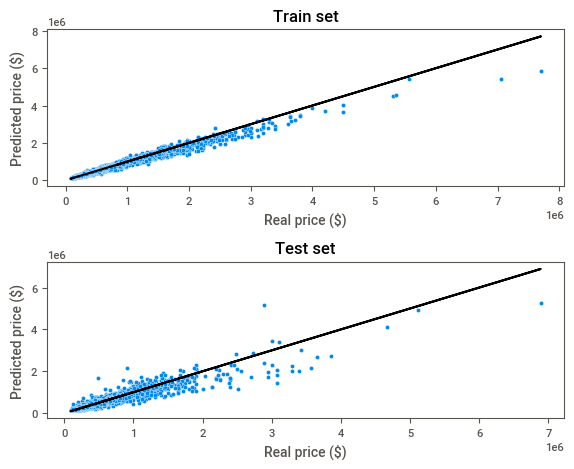

In [49]:
fig, ax = plt.subplots(2,1)
sns.scatterplot(x=y_train,y=y_train_pred,ax=ax[0]);
ax[0].plot(y_train,y_train, color= "black")
ax[0].set_xlabel("Real price ($)")
ax[0].set_ylabel("Predicted price ($)")
ax[0].set_title("Train set")
#ax[0].set_xscale("log")
#ax[0].set_yscale("log")
sns.scatterplot(x=y_test,y=y_test_pred,ax=ax[1]);
ax[1].plot(y_test,y_test, color= "black")
ax[1].set_xlabel("Real price ($)")
ax[1].set_ylabel("Predicted price ($)")
ax[1].set_title("Test set")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")
plt.tight_layout()
ax[0].ticklabel_format(axis="x",style="sci",scilimits=(0,0))
ax[0].ticklabel_format(axis="y",style="sci",scilimits=(0,0))
ax[1].ticklabel_format(axis="x",style="sci",scilimits=(0,0))
ax[1].ticklabel_format(axis="y",style="sci",scilimits=(0,0))
plt.show()
fig.savefig('../visualization/Train_VS_Test.png', transparent=True)